In [1]:
%matplotlib inline  
from fastai.vision import *
from fastai.data_block import _maybe_squeeze
from fastai.callbacks import *
from sklearn.model_selection import StratifiedKFold
from joblib import load, dump
from efficientnet_pytorch import EfficientNet
from ranger import *
from mxresnet import *

Mish activation loaded...


In [2]:
def strt_split(x, y, n_folds=5, random_seed = 42, path=Path('')):  
    try: 
        val_name = load('val_idx.joblib')
    except:
        skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_seed)
        val_name = [(val_idx, trn_idx) for trn_idx, val_idx in skf.split(x, y)]
        dump(val_name,'val_idx.joblib')
    return val_name

def modified_label_from_df(self, cols:IntsOrStrs=1, label_cls:Callable=None, **kwargs):
    "Label `self.items` from the values in `cols` in `self.inner_df`."
    self.inner_df.labels.fillna('', inplace=True)
    labels = self.inner_df.iloc[:,df_names_to_idx(cols, self.inner_df)]
    assert labels.isna().sum().sum() == 0, f"You have NaN values in column(s) {cols} of your dataframe, please fix it."
    if is_listy(cols) and len(cols) > 1 and (label_cls is None or label_cls == MultiCategoryList):
        new_kwargs,label_cls = dict(one_hot=True, classes= cols),MultiCategoryList
        kwargs = {**new_kwargs, **kwargs}
    return self._label_from_list(_maybe_squeeze(labels), label_cls=label_cls, **kwargs)


def flattenAnneal(learn:Learner, lr:float, n_epochs:int, start_pct:float, SUFFIX = 'PHASE_1_COS'):
    n = len(learn.data.train_dl)
    anneal_start = int(n*n_epochs*start_pct)
    anneal_end = int(n*n_epochs) - anneal_start
    phases = [TrainingPhase(anneal_start).schedule_hp('lr', lr),
             TrainingPhase(anneal_end).schedule_hp('lr', lr, anneal=annealing_cos)]
    sched = GeneralScheduler(learn, phases)
    learn.callbacks.append(sched)
    learn.callbacks.append(SaveModelCallback(learn, every='improvement', monitor='valid_loss', name = f'{EXP_NAME}_{SUFFIX}'))
    learn.fit(n_epochs)

In [3]:
PATH = Path('..')
FOLD =0
EXP_NAME =      f'NB_EXP_10_CV_{FOLD}_MIXUP'
IMG_TRAIN_224 = PATH/'train_images_224'
IMG_TEST_224  = PATH/'test_images_224'
DF_TRAIN =      pd.read_csv(PATH/'train_labels_as_strings.csv')
DF_SUBMI =      pd.read_csv(PATH/'stage_1_sample_submission.csv')
BS =            384
SZ =            224



DF_SUBMI['fn'] = DF_SUBMI.ID.apply(lambda x: '_'.join(x.split('_')[:2]) + '.png')
DF_TRAIN['labels'].fillna('', inplace=True)
VAL_IDX = strt_split(DF_TRAIN['fn'], DF_TRAIN['labels'])[FOLD]

In [4]:
ItemList.label_from_df = modified_label_from_df
test_fns = DF_SUBMI.fn.unique()
tfms = get_transforms(max_rotate=30, xtra_tfms= zoom_crop(scale=(1.05, 1.4), do_rand=True))

data = (ImageList.from_csv('..', 'train_labels_as_strings.csv', folder=IMG_TRAIN_224.name)
        .split_by_idxs(valid_idx=VAL_IDX[0], train_idx=VAL_IDX[1])
        .label_from_df(label_delim=' ')
        .transform(tfms = tfms,size=SZ)
        .add_test('../' +IMG_TEST_224.name + '/' + test_fns)
        .databunch(bs=BS))

        

In [5]:
md_xrsa =  mxresnet50(c_out=data.c, sa=True)
opt_func = partial(Ranger, betas=(0.95,0.99), eps=1e-6)

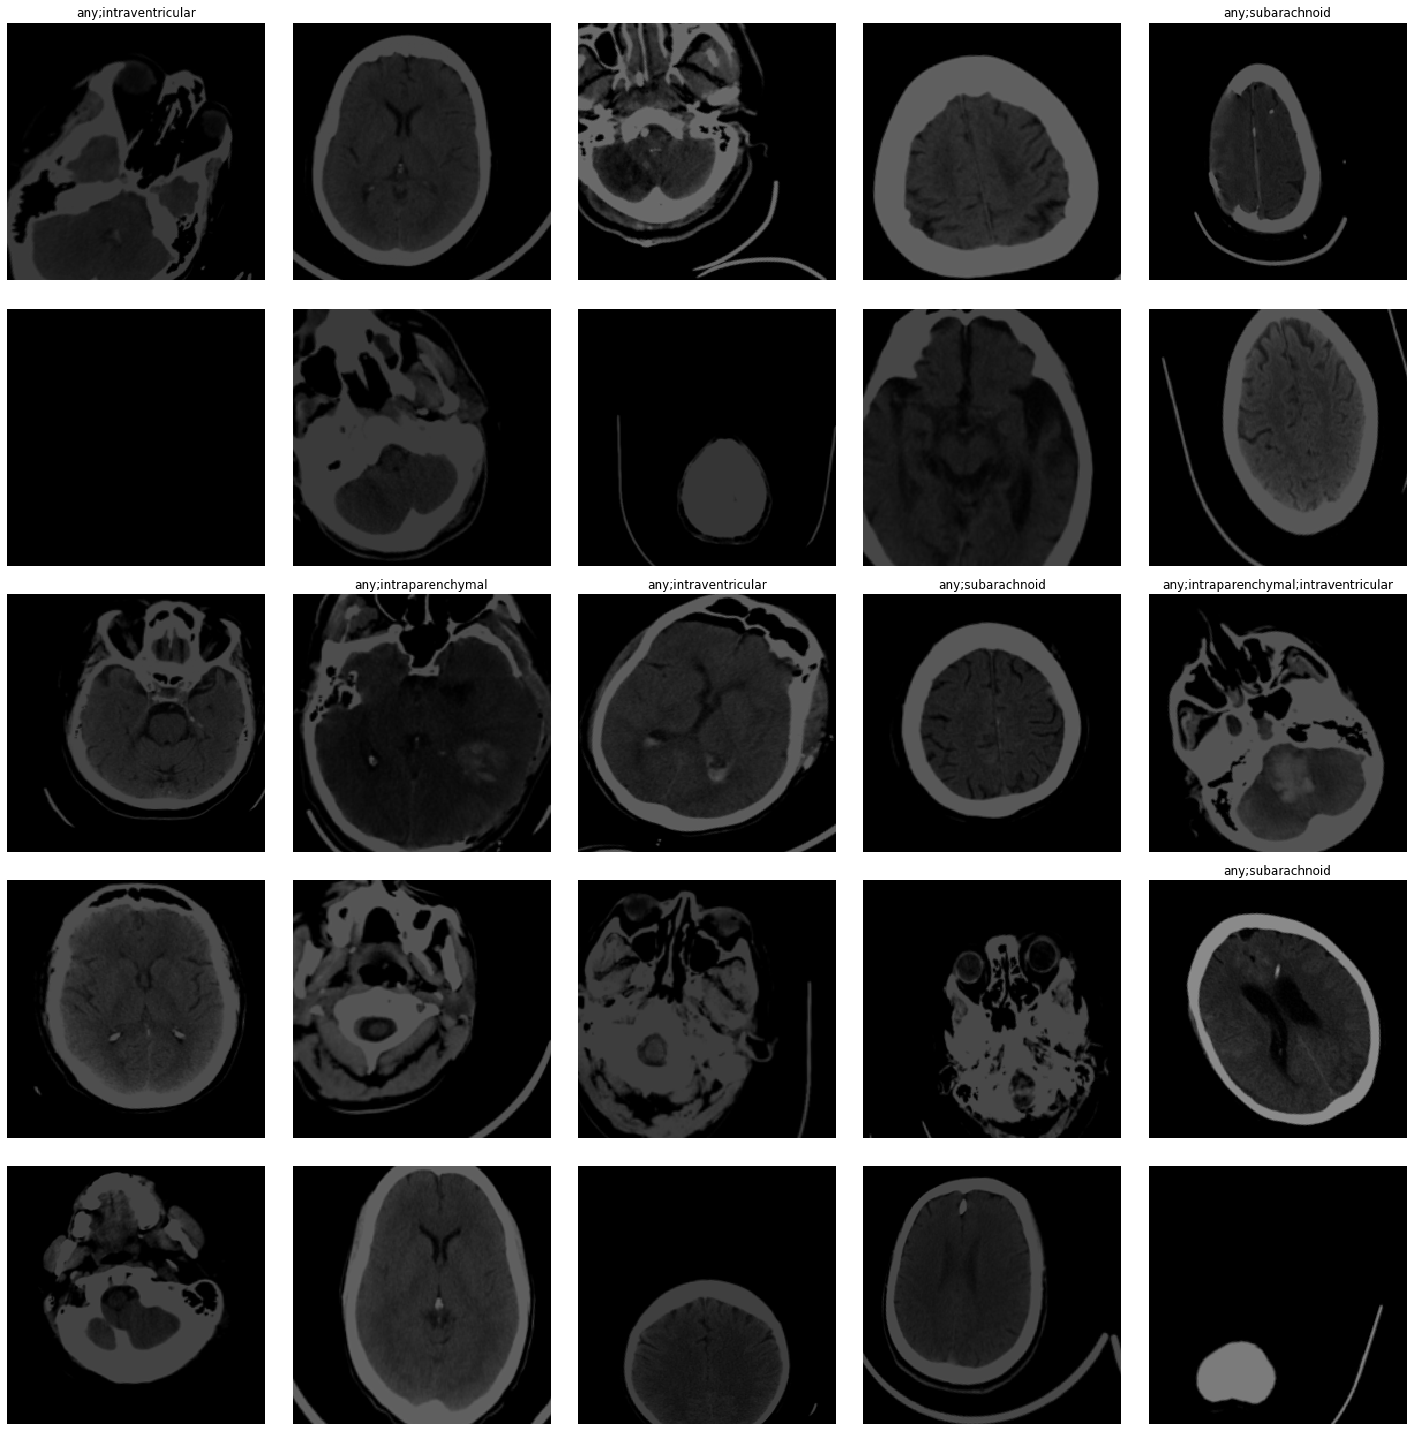

In [6]:
data.show_batch()

In [7]:
learn = Learner(data,
                md_xrsa,
                wd=1e-2,
                bn_wd=False, 
                true_wd=True, 
                opt_func=opt_func,
                metrics=[accuracy_thresh])

learn.model = nn.DataParallel(learn.model)
learn.to_fp16()
learn.mixup(stack_y=False)
learn.unfreeze()

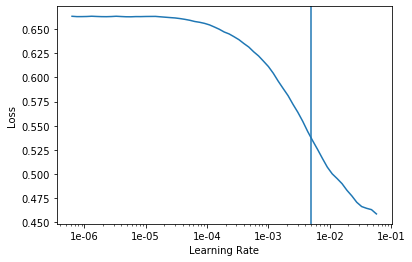

In [27]:
lr = 1e-2/2
learn.recorder.plot()
plt.axvline(lr)

In [8]:
lr = 1e-2/2
flattenAnneal(learn, lr, 25, 0.7)

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.134393,0.105261,0.962640,20:53
1,0.126117,0.091926,0.967914,20:58
2,0.120482,0.085671,0.969954,20:57
3,0.115473,0.087723,0.970503,20:58
4,0.114371,0.079722,0.972542,20:49
5,0.115807,0.078853,0.972460,20:51
6,0.110652,0.077888,0.972972,20:57
7,0.110216,0.076040,0.973030,20:53
8,0.108845,0.073136,0.974279,20:49
9,0.108837,0.071733,0.974619,20:49


Better model found at epoch 0 with valid_loss value: 0.10526123642921448.
Better model found at epoch 1 with valid_loss value: 0.0919264405965805.
Better model found at epoch 2 with valid_loss value: 0.08567100018262863.
Better model found at epoch 4 with valid_loss value: 0.07972154766321182.
Better model found at epoch 5 with valid_loss value: 0.07885269075632095.
Better model found at epoch 6 with valid_loss value: 0.07788821309804916.
Better model found at epoch 7 with valid_loss value: 0.07604008913040161.
Better model found at epoch 8 with valid_loss value: 0.07313553243875504.
Better model found at epoch 9 with valid_loss value: 0.0717325285077095.
Better model found at epoch 12 with valid_loss value: 0.07160180062055588.
Better model found at epoch 13 with valid_loss value: 0.06936043500900269.
Better model found at epoch 15 with valid_loss value: 0.06696104258298874.
Better model found at epoch 18 with valid_loss value: 0.06688415259122849.
Better model found at epoch 19 with 

In [18]:
def get_preds(learn:Learner, sub_fn: str=f'{EXP_NAME}_PHASE_2_1CYL', TTA: bool = False, dt_type = DatasetType.Test):
    if TTA:
        learn.to_fp32()
        preds, targs = learn.TTA(ds_type=dt_type)
        sub_fn = f'{sub_fn}_TTA'
    else:
        preds, targs = learn.get_preds(dt_type)
    ids = []
    labels = []

    for fn, pred in zip(test_fns, preds):
        for i, label in enumerate(data.train_ds.classes):
            ids.append(f"{fn.split('.')[0]}_{label}")
            predicted_probability = '{0:1.10f}'.format(pred[i].item())
            labels.append(predicted_probability)
    pd.DataFrame({'ID': ids, 'Label': labels}).to_csv(f'{sub_fn}.csv', index=False)

In [10]:
get_preds(learn)

In [11]:
get_preds(learn, TTA=True)

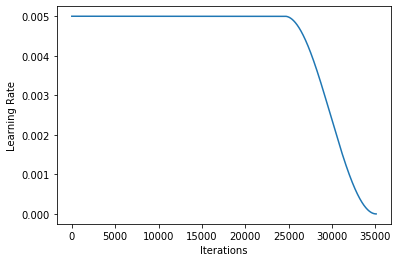

In [14]:
learn.recorder.plot_lr()

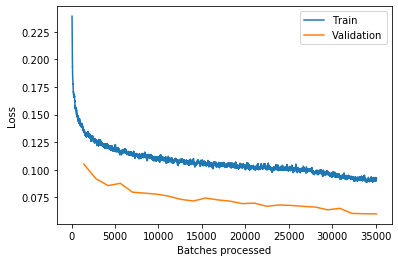

In [21]:
learn.recorder.plot_losses(skip_start=60)

In [6]:
learn = Learner(data,
                md_xrsa,
                wd=1e-2,
                bn_wd=False, 
                true_wd=True, 
                metrics=[accuracy_thresh])

learn.model = nn.DataParallel(learn.model)
learn.to_fp16()
learn.load('NB_EXP_10_CV_0_MIXUP_PHASE_1_COS')
learn.mixup(stack_y=False)
learn.unfreeze()

In [7]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


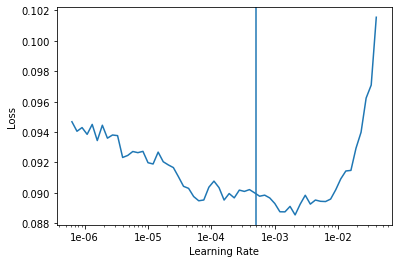

In [13]:
lr = 1e-3/2
learn.recorder.plot()
plt.axvline(lr)

In [15]:
SUFFIX = 'PHASE_2_1CYL'
learn.fit_one_cycle(30,
                    lr, 
                    pct_start=0.15,
                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='valid_loss', name = f'{EXP_NAME}_{SUFFIX}')])

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.090692,0.059627,0.978431,20:45
1,0.092013,0.060088,0.978282,20:54
2,0.091978,0.060681,0.978116,20:56
3,0.091475,0.061900,0.977865,20:58
4,0.091867,0.062044,0.977518,20:57
5,0.090940,0.062542,0.977764,20:58
6,0.090726,0.061644,0.977944,20:59
7,0.090828,0.061760,0.978189,20:53
8,0.092180,0.061144,0.978399,21:00
9,0.089749,0.063648,0.977810,20:56


Better model found at epoch 0 with valid_loss value: 0.05962735414505005.
Better model found at epoch 11 with valid_loss value: 0.058969467878341675.
Better model found at epoch 16 with valid_loss value: 0.05829475447535515.
Better model found at epoch 17 with valid_loss value: 0.05790076404809952.


In [19]:
get_preds(learn)

In [ ]:
get_preds(learn, TTA=True)

In [ ]:
learn.recorder.plot_lr()

In [ ]:
learn.recorder.plot_losses(skip_start=60)

In [ ]:
!sudo shutdown